# Exploring the dataset

In this competition, you will be predicting multiple targets of the Mechanism of Action (MoA) response(s) of different samples (sig_id), given various inputs such as gene expression data and cell viability data.

Two notes:

- the training data has an additional (optional) set of MoA labels that are not included in the test data and not used for scoring.
- the re-run dataset has approximately 4x the number of examples seen in the Public test.

- `train_features.csv` - Features for the training set. Features g- signify gene expression data, and c- signify cell viability data. cp_type indicates samples treated with a compound (cp_vehicle) or with a control perturbation (ctrl_vehicle); control perturbations have no MoAs; cp_time and cp_dose indicate treatment duration (24, 48, 72 hours) and dose (high or low).  
- `train_drug.csv` - This file contains an anonymous drug_id for the training set only.
- `train_targets_scored.csv` - The binary MoA targets that are scored.
- `train_targets_nonscored.csv` - Additional (optional) binary MoA responses for the training data. These are not predicted nor scored.
- `test_features.csv` - Features for the test data. You must predict the probability of each scored MoA for each row in the test data.
- `sample_submission.csv` - A submission file in the correct format.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

plt.rcParams['figure.figsize'] = (2, 2)

In [2]:
train_features = pd.read_csv('data/train_features.csv', index_col=0)
train_drug = pd.read_csv('data/train_drug.csv', index_col=0)
train_targets_scored = pd.read_csv('data/train_targets_scored.csv', index_col=0)
train_targets_nonscored = pd.read_csv('data/train_targets_nonscored.csv', index_col=0)
test_features = pd.read_csv('data/test_features.csv', index_col=0)

## Training data exploration

In [3]:
train_features.sample(10)

,cp_type,cp_time,cp_dose,g-0,g-1,g-2,g-3,g-4,g-5,g-6,...,c-90,c-91,c-92,c-93,c-94,c-95,c-96,c-97,c-98,c-99
sig_id,,,,,,,,,,,,,,,,,,,,,
id_8701e75c1,trt_cp,24,D2,-0.1326,0.9574,0.6944,-0.5204,-0.4031,-0.0065,-1.0970,...,0.6318,0.8372,-0.0526,0.8775,0.6168,0.6245,0.2640,0.3077,0.4572,0.2043
id_5cd33072b,ctl_vehicle,72,D1,-0.7247,-1.4930,-1.2470,0.9841,-0.3240,1.8480,1.4330,...,-0.2563,-0.0775,0.0481,0.4293,-0.1192,0.7665,-0.2626,0.3944,0.4973,1.2710
id_b76098a8e,trt_cp,48,D1,0.1028,0.1213,-0.6131,0.2239,-0.1358,0.0281,-0.4134,...,-1.8590,-0.5463,1.1120,-0.1960,-1.2100,0.1194,-0.0651,-1.2340,-0.3980,-0.7021
id_d7e8e2276,trt_cp,48,D2,-0.9528,-1.9510,-0.3943,0.3142,-2.1370,-0.7246,-0.1253,...,1.1690,0.5579,1.4220,1.2980,1.5950,0.4957,1.0560,1.5260,-1.6670,1.3090
id_f70be1f52,trt_cp,72,D2,6.5690,0.2987,0.3974,4.5540,2.5790,-4.6680,1.4620,...,-10.0000,-10.0000,-7.9540,-10.0000,-10.0000,-9.7870,-10.0000,-9.9310,-9.6020,-7.5850
id_74f10e27e,trt_cp,72,D2,1.4560,1.0980,1.0990,1.0600,-0.1266,-0.9110,-1.1330,...,-9.0170,-4.0970,-9.7650,-3.1010,-4.5750,-9.2060,-4.5550,-4.5790,-3.4230,-5.5500
id_74140eecb,trt_cp,72,D1,2.0090,0.6963,0.0069,-0.3291,0.3084,0.0206,1.2760,...,0.2360,1.6020,1.0050,0.5783,0.5459,1.0750,1.3940,0.6743,0.3001,0.9362
id_d21752216,trt_cp,72,D1,0.1138,-0.3037,0.0229,-0.3916,-0.2493,1.0490,-1.0590,...,0.4136,0.2609,0.4845,-0.4145,-0.6622,0.2495,-0.5748,0.2669,-2.6620,-0.5099
id_fa87f92b6,trt_cp,72,D2,0.6334,0.0998,-0.4418,-0.2552,0.3646,0.3041,0.4933,...,0.3118,-0.5894,0.2670,-0.5950,-0.7665,-0.0785,-1.4350,-0.0017,-0.6996,-0.4067


In [4]:
gexp_cols = train_features.columns[train_features.columns.str.startswith("g-")]
viability_cols = train_features.columns[train_features.columns.str.startswith("c-")]
print(f'Number of gexp features: {len(gexp_cols)}')
print(f'Number of viability features: {len(viability_cols)}')

Number of gexp features: 772
Number of viability features: 100


In [5]:
print(f"NULLs in the data: {train_features.isnull().sum().sum()}")
print(f"NaNs in the data: {train_features.isna().sum().sum()}")

NULLs in the data: 0
NaNs in the data: 0


Data is clean, no NaN or NULL values.

### Gexp features exploration

These values look like normalized gene expression levels, positive values correspond to genes that are up-regulated after treatment, and negative values are the genes that are down-regulated after treatment.

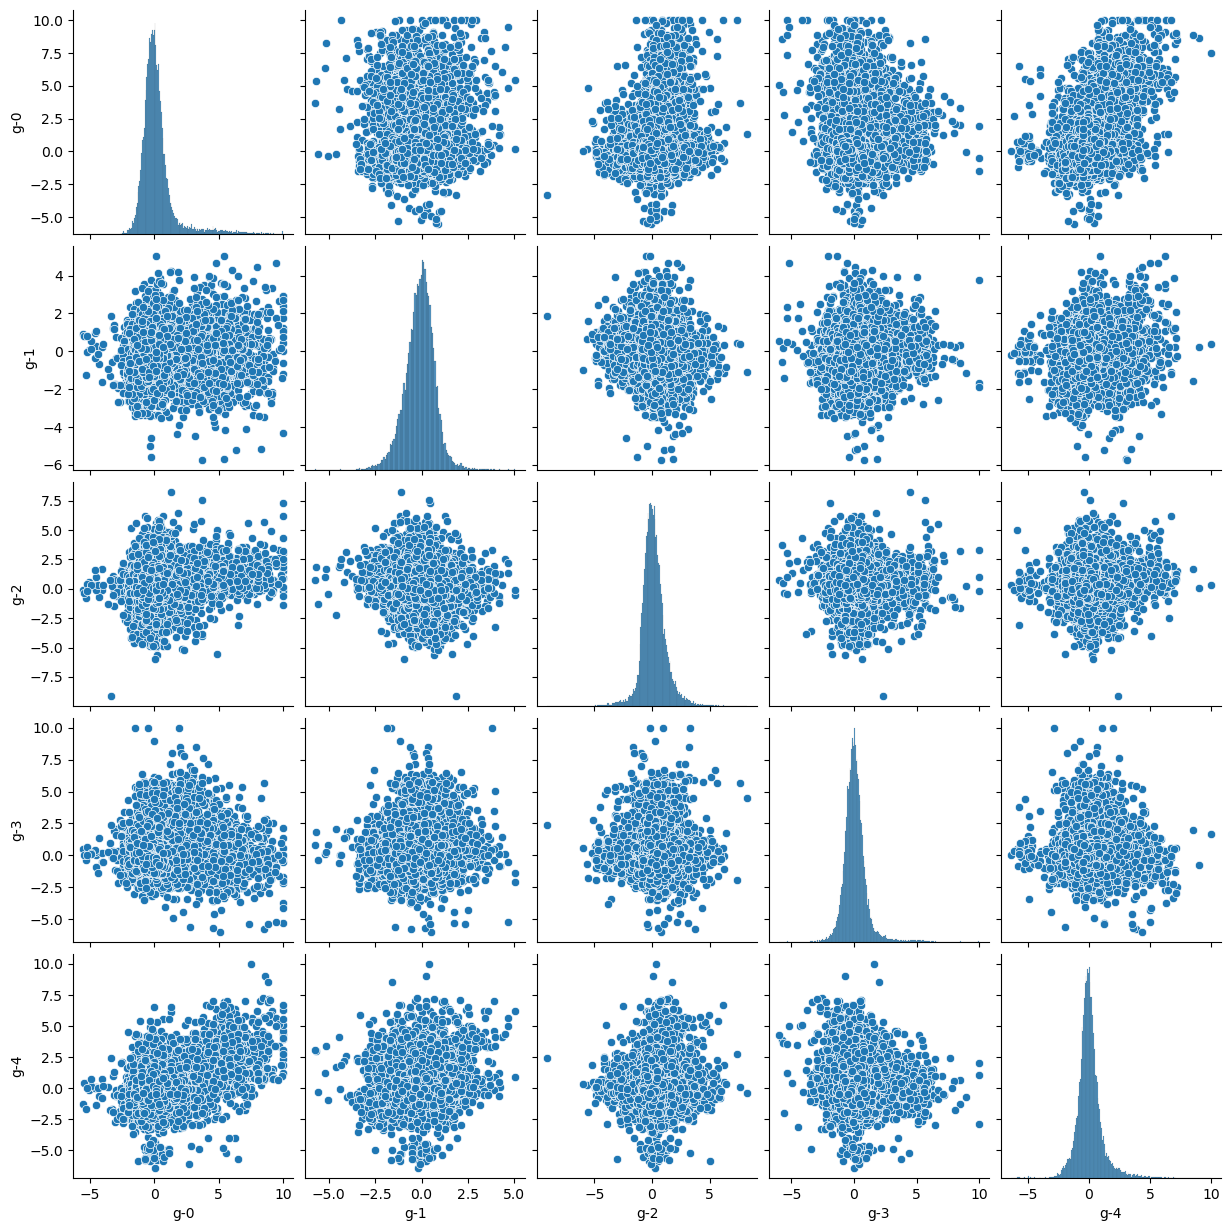

In [6]:
sns.pairplot(train_features[gexp_cols[:5]])

Gexp features look to be gaussian-distributed with mean ~0. Some of them have tails (e.g. g-0). At least in these first 5 genes no correlations seems obvious.

In [7]:
def my_heatmap(input_features):
    corr_gexp = input_features.corr()
    g = sns.clustermap(corr_gexp, figsize=(5, 5), cmap='RdBu_r', vmin=-1, vmax=1)
    mask = np.triu(np.ones_like(corr_gexp))
    values = g.ax_heatmap.collections[0].get_array().reshape(corr_gexp.shape)
    new_values = np.ma.array(values, mask=mask)
    g.ax_heatmap.collections[0].set_array(new_values)
    g.ax_col_dendrogram.set_visible(False)
    g.ax_heatmap.set(yticklabels=[])
    g.ax_heatmap.tick_params(right=False)
    g.ax_cbar.set_position([0.7, 0.6, 0.03, 0.1])

/Users/carlo.dedonno/miniconda3/envs/scpoli/lib/python3.11/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


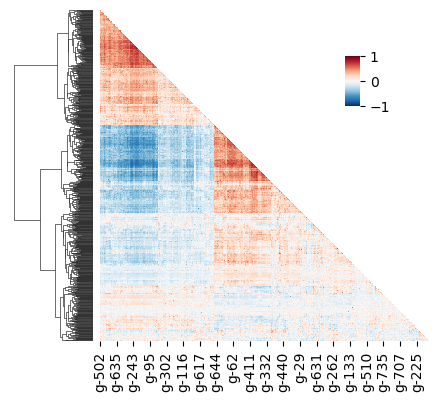

In [8]:
my_heatmap(train_features[gexp_cols])


There are two fairly large groups of genes with correlated expressions. 

### Viability features exploration

Each feature measures the viability of the drug on a certain cell type. With values > 0 indicating proliferation, values < 0 a decreased proliferation rate or even death.

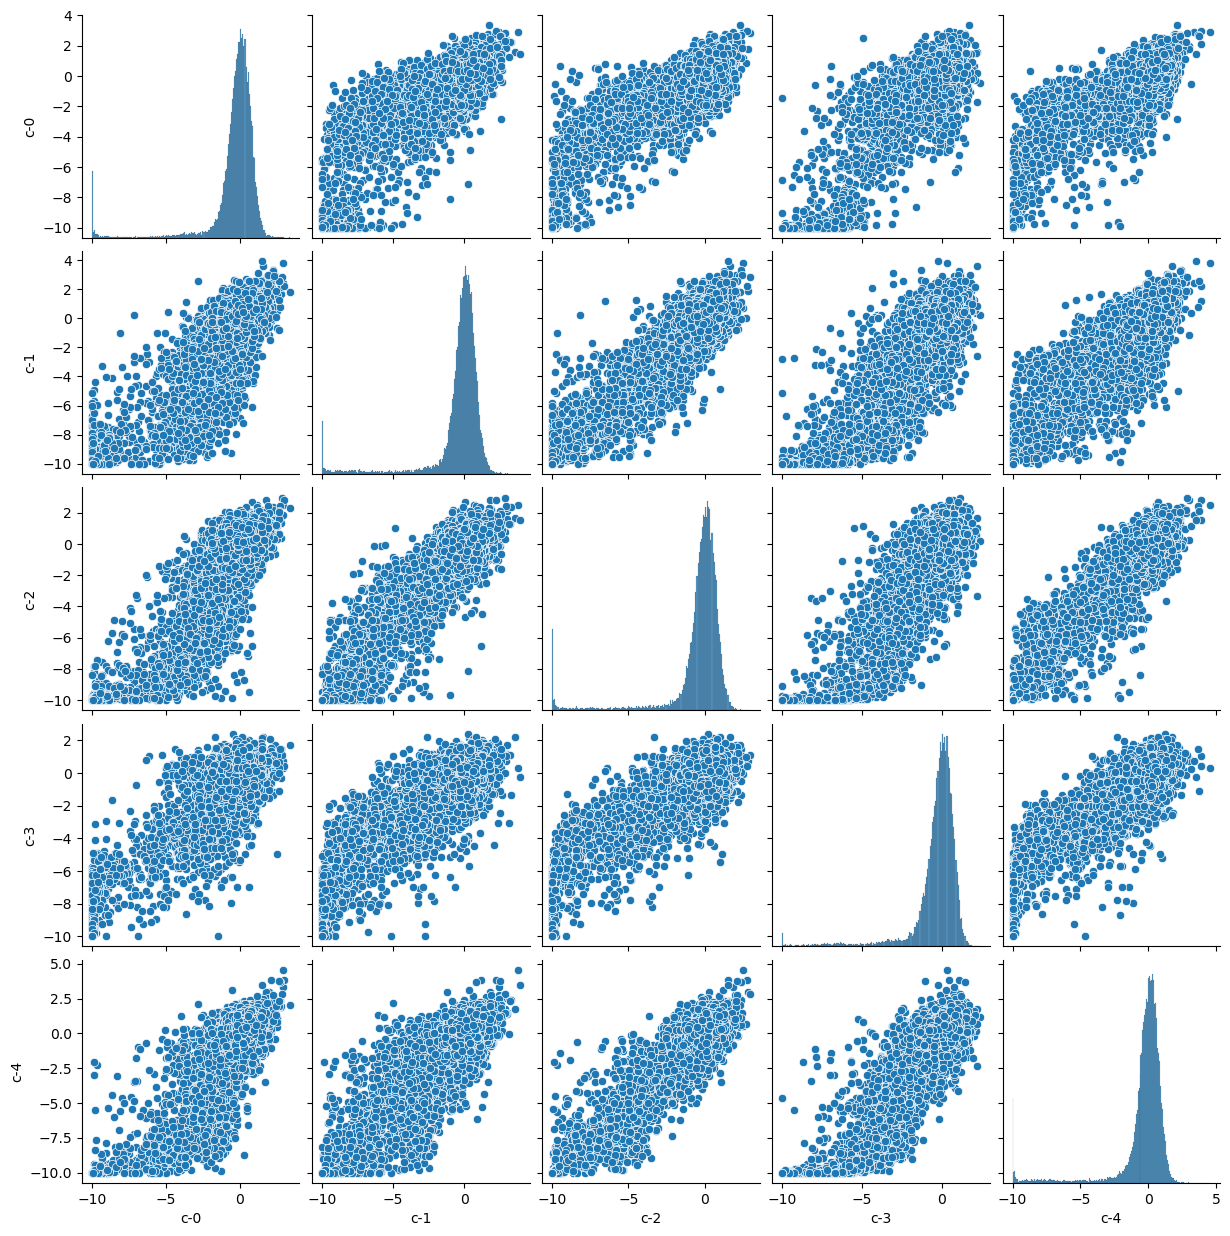

In [9]:
sns.pairplot(train_features[viability_cols[:5]])

Viability features appear to have a lower bound at -10. They have a peak around 0, but distinct tails towards negative values. Correlations are evident.

/Users/carlo.dedonno/miniconda3/envs/scpoli/lib/python3.11/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


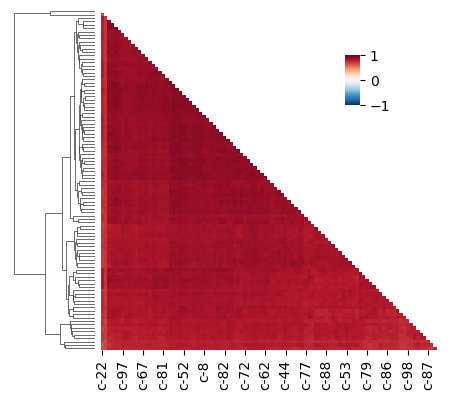

In [10]:
my_heatmap(train_features[viability_cols])

It would appear all viability features are heavily correlated with each other.

## Feature balance

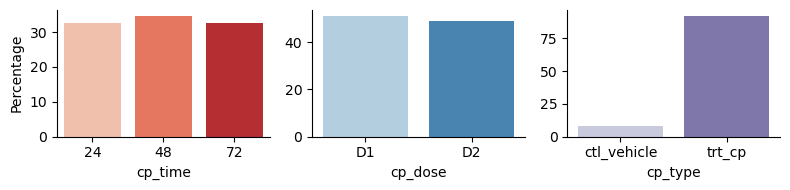

In [11]:
fig, ax = plt.subplots(1, 3, figsize=(8, 2))
d = train_features.groupby('cp_time').size() / len(train_features) * 100
sns.barplot(x=d.index, y=d.values, ax=ax[0], palette='Reds')
d = train_features.groupby('cp_dose').size() / len(train_features) * 100
sns.barplot(x=d.index, y=d.values, ax=ax[1], palette='Blues')
d = train_features.groupby('cp_type').size() / len(train_features) * 100
sns.barplot(x=d.index, y=d.values, ax=ax[2], palette='Purples')
sns.despine()
ax[0].set_ylabel("Percentage")
plt.tight_layout()

Dosage and treatment time classes are balanced, there are about 9% vehicle data points.

In [12]:
pd.crosstab(train_features['cp_time'], train_features['cp_dose'])

cp_dose,D1,D2
cp_time,,
24,3886,3886
48,4354,3896
72,3907,3885


In [13]:
pd.crosstab(train_features['cp_type'], train_features['cp_time'])

cp_time,24,48,72
cp_type,,,
ctl_vehicle,606,648,612
trt_cp,7166,7602,7180


In [14]:
pd.crosstab(train_features['cp_type'], train_features['cp_dose'])

cp_dose,D1,D2
cp_type,,
ctl_vehicle,951,915
trt_cp,11196,10752


Classes are balanced also across values, no interactions visible.

## Target data exploration

In [15]:
train_targets_scored

,5-alpha_reductase_inhibitor,11-beta-hsd1_inhibitor,acat_inhibitor,acetylcholine_receptor_agonist,acetylcholine_receptor_antagonist,acetylcholinesterase_inhibitor,adenosine_receptor_agonist,adenosine_receptor_antagonist,adenylyl_cyclase_activator,adrenergic_receptor_agonist,...,tropomyosin_receptor_kinase_inhibitor,trpv_agonist,trpv_antagonist,tubulin_inhibitor,tyrosine_kinase_inhibitor,ubiquitin_specific_protease_inhibitor,vegfr_inhibitor,vitamin_b,vitamin_d_receptor_agonist,wnt_inhibitor
sig_id,,,,,,,,,,,,,,,,,,,,,
id_000644bb2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
id_000779bfc,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
id_000a6266a,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
id_0015fd391,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
id_001626bd3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
id_fffb1ceed,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
id_fffb70c0c,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
id_fffc1c3f4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [16]:
train_targets_scored.isin([0, 1]).all().all()

True

The targets are binary labels.

In [62]:
len(train_drug.drop_duplicates())

3289

There are 3289 unique drugs.

Text(0, 0.5, 'Percentage')

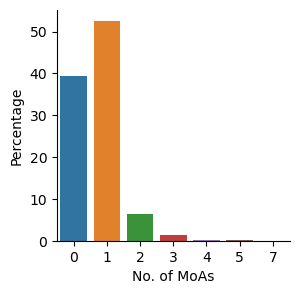

In [17]:
fig, ax = plt.subplots(1, 1, figsize=(3, 3))
d = train_targets_scored.sum(axis=1).value_counts() / len(train_targets_scored) * 100
sns.barplot(x=d.index, y=d.values, ax=ax)
sns.despine()
ax.set_xlabel('No. of MoAs')
ax.set_ylabel('Percentage')

Most samples have 1 MoA, some have multiple, a few of them even up to 7. There is also a very big group with no mode of action assigned.

Text(0, 0.5, 'No. of samples')

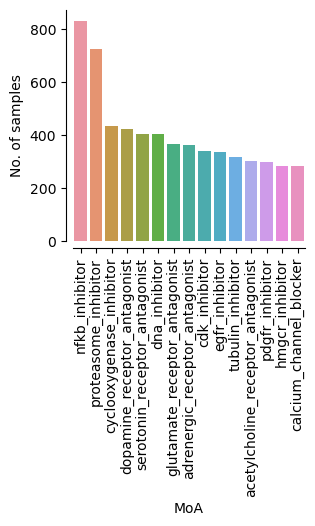

In [56]:
fig, ax = plt.subplots(1, 1, figsize=(3, 3))
d = train_targets_scored.sum(axis=0).sort_values(ascending=False)[:15]
sns.barplot(x=d.index, y=d.values, ax=ax)
sns.despine(offset=5)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
ax.set_xlabel('MoA')
ax.set_ylabel('No. of samples')

Text(0, 0.5, 'No. of assayed drugs')

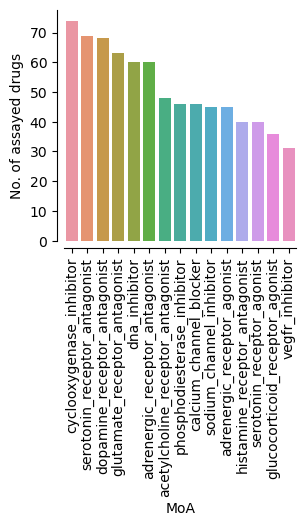

In [60]:
fig, ax = plt.subplots(1, 1, figsize=(3, 3))
d = (
    train_targets_scored
    .loc[train_drug.drop_duplicates().index]
    .sum(axis=0)
    .sort_values(ascending=False)[:15]
)
sns.barplot(x=d.index, y=d.values, ax=ax)
sns.despine(offset=5)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
ax.set_xlabel('MoA')
ax.set_ylabel('No. of assayed drugs')

Text(0, 0.5, 'No. of samples')

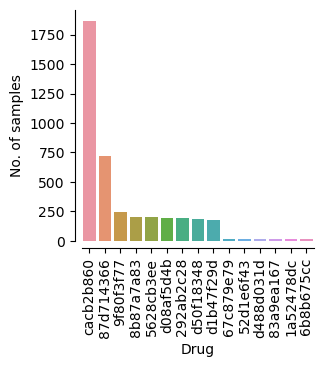

In [39]:
fig, ax = plt.subplots(1, 1, figsize=(3, 3))
d = train_drug.groupby('drug_id').size().sort_values(ascending=False)[:15]
sns.barplot(x=d.index, y=d.values, ax=ax)
sns.despine(offset=5)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
ax.set_xlabel('Drug')
ax.set_ylabel('No. of samples')

In [41]:
(
    train_features
    .reindex(train_drug[train_drug['drug_id'] == 'cacb2b860'].index)
    .groupby('cp_type')
    .size()
)

cp_type
ctl_vehicle    1866
dtype: int64

As expected, the drug_id with the most appearances corresponds to the vehicle condition.

In [42]:
(
    train_features
    .reindex(train_drug[train_drug['drug_id'] == '87d714366'].index)
    .groupby('cp_type')
    .size()
)

cp_type
trt_cp    718
dtype: int64

On the other hand the second most frequent drug corresponds to a treatment, it appears as though the drugs are not balanced in this dataset.

# PCA visualization 

In [18]:
def pca_plot(features_transformed, train_features, color_cat, pca_object, palette, ax):
    sns.scatterplot(
        x=features_transformed[:, 0], 
        y=features_transformed[:, 1], 
        hue=train_features[color_cat], 
        s=10, 
        alpha=0.7,
        ax=ax,
        palette=palette
    )
    ax.set_xlabel(f'PC1 (var={pca_object.explained_variance_ratio_[0] * 100:.1f}%)')
    ax.set_ylabel(f'PC2 (var={pca_object.explained_variance_ratio_[1] * 100:.1f}%)')

In [19]:
from sklearn.decomposition import PCA

### PCA of gene expression features

In [20]:
pca = PCA(n_components=10)
features_transformed = pca.fit_transform(train_features[gexp_cols])

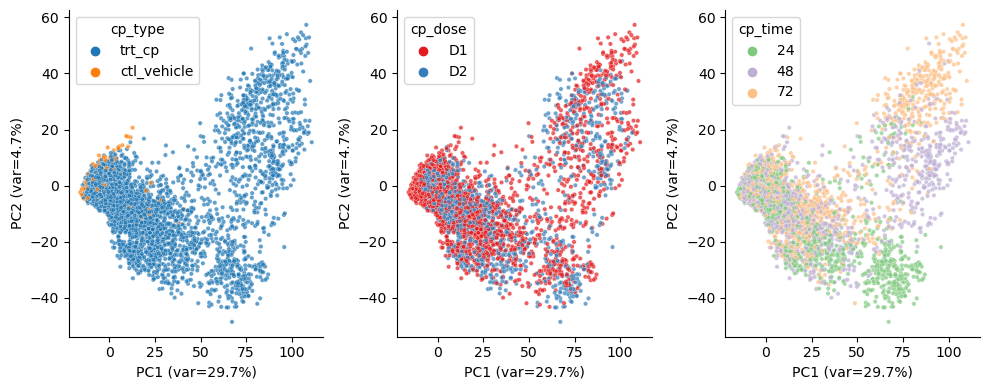

In [21]:
fig, ax = plt.subplots(1, 3, figsize=(10, 4))
pca_plot(features_transformed, train_features, 'cp_type', pca, 'tab10', ax[0])
pca_plot(features_transformed, train_features, 'cp_dose', pca, 'Set1', ax[1])
pca_plot(features_transformed, train_features, 'cp_time', pca, 'Accent', ax[2])
sns.despine()
plt.tight_layout()

### PCA of viability features

In [22]:
pca = PCA(n_components=10)
features_transformed = pca.fit_transform(train_features[viability_cols])

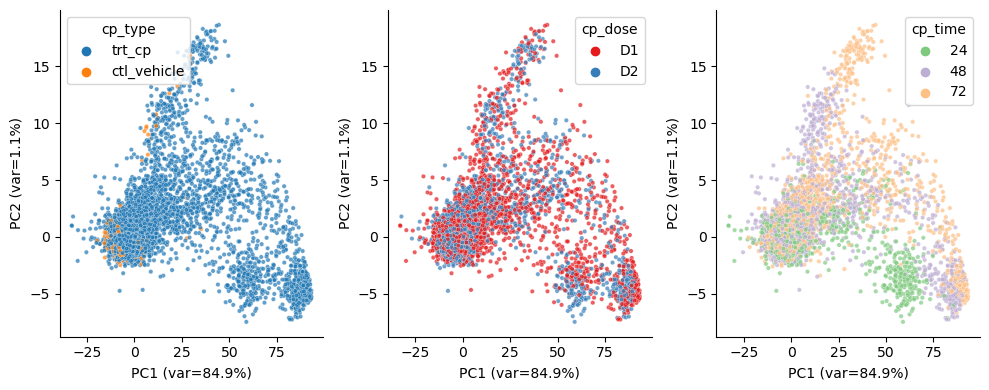

In [23]:
fig, ax = plt.subplots(1, 3, figsize=(10, 4))
pca_plot(features_transformed, train_features, 'cp_type', pca, 'tab10', ax[0])
pca_plot(features_transformed, train_features, 'cp_dose', pca, 'Set1', ax[1])
pca_plot(features_transformed, train_features, 'cp_time', pca, 'Accent', ax[2])
sns.despine()
plt.tight_layout()

### PCA of joint features

In [24]:
pca = PCA(n_components=10)
features_transformed = pca.fit_transform(train_features[gexp_cols.to_list() + viability_cols.to_list()])

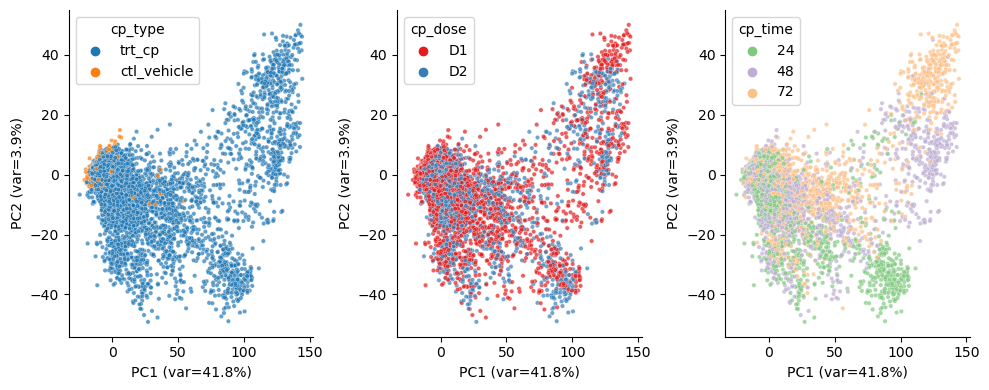

In [25]:
fig, ax = plt.subplots(1, 3, figsize=(10, 4))
pca_plot(features_transformed, train_features, 'cp_type', pca, 'tab10', ax[0])
pca_plot(features_transformed, train_features, 'cp_dose', pca, 'Set1', ax[1])
pca_plot(features_transformed, train_features, 'cp_time', pca, 'Accent', ax[2])
sns.despine()
plt.tight_layout()